In [ ]:
pip install mtcnn

Face Detection using Python

In [ ]:
from mtcnn import MTCNN
import cv2
detector = MTCNN()
#Load a videopip TensorFlow
video_capture = cv2.VideoCapture(0)
 
while (True):
    ret, frame = video_capture.read()
    frame = cv2.resize(frame, (600, 400))
    boxes = detector.detect_faces(frame)
    if boxes:
 
        box = boxes[0]['box']
        conf = boxes[0]['confidence']
        x, y, w, h = box[0], box[1], box[2], box[3]
 
        if conf > 0.5:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 255), 1)
 
    cv2.imshow("Frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
 
video_capture.release()
cv2.destroyAllWindows()

Face Detection using OpenCV

In [ ]:
import cv2
import os
cascPath = os.path.dirname(
    cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"
faceCascade = cv2.CascadeClassifier(cascPath)
video_capture = cv2.VideoCapture(0)
while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.1,
                                         minNeighbors=5,
                                         minSize=(60, 60),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
    for (x,y,w,h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h),(0,255,0), 2)
        # Display the resulting frame
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()

Create a model to recognise faces wearing a mask

In [ ]:
pip install imutils

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

D:\Coding\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Coding\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Coding\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Coding\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' 

In [2]:
imagePaths = list(paths.list_images('C:/Users/joshu/Downloads/dataset'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

D:\Coding\Anaconda\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [4]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_shape=(224, 224, 3))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [6]:
INIT_LR = 1e-4
EPOCHS = 5
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
95/95 [==============================] - 271s 3s/step - loss: 0.5866 - acc: 0.7123 - val_loss: 0.3653 - val_acc: 0.8488
Epoch 2/5
95/95 [==============================] - 264s 3s/step - loss: 0.2996 - acc: 0.8777 - val_loss: 0.3410 - val_acc: 0.8631
Epoch 3/5
95/95 [==============================] - 295s 3s/step - loss: 0.2506 - acc: 0.9015 - val_loss: 0.3329 - val_acc: 0.8657
Epoch 4/5
95/95 [==============================] - 284s 3s/step - loss: 0.1983 - acc: 0.9245 - val_loss: 0.3957 - val_acc: 0.8592
Epoch 5/5
95/95 [==============================] - 276s 3s/step - loss: 0.1777 - acc: 0.9334 - val_loss: 0.3143 - val_acc: 0.8774


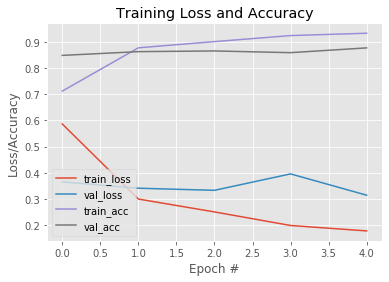

In [7]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [8]:
#To save the trained model
model.save('mask_recog_ver2.h5')

How to do Real-time Mask Detection 

In [9]:
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
 
cascPath = os.path.dirname(
    cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"
faceCascade = cv2.CascadeClassifier(cascPath)
model = load_model("mask_recog_ver2.h5")
 
video_capture = cv2.VideoCapture(0)
while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.1,
                                         minNeighbors=5,
                                         minSize=(60, 60),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
    faces_list=[]
    preds=[]
    for (x, y, w, h) in faces:
        face_frame = frame[y:y+h,x:x+w]
        face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
        face_frame = cv2.resize(face_frame, (224, 224))
        face_frame = img_to_array(face_frame)
        face_frame = np.expand_dims(face_frame, axis=0)
        face_frame =  preprocess_input(face_frame)
        faces_list.append(face_frame)
        if len(faces_list)>0:
            preds = model.predict(faces_list)
        for pred in preds:
            (mask, withoutMask) = pred
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        cv2.putText(frame, label, (x, y- 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
 
        cv2.rectangle(frame, (x, y), (x + w, y + h),color, 2)
        # Display the resulting frame
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


KeyboardInterrupt: 